In [1]:
# Performs maximum likelihood estimation on quantum state tomography data obtained from Stephenson et. al.

import numpy as np
import pandas as pd
from scipy.linalg import sqrtm

# Pauli matrix eigenvectors
pauli_evecs = { 
    0 : np.array([1, 0]), # z+
    1 : np.array([0, 1]), # z-
    2 : np.array([1, 1]) / np.sqrt(2), # x+
    3 : np.array([1, -1]) / np.sqrt(2), # x-
    4 : np.array([1, 1j]) / np.sqrt(2), # y+
    5 : np.array([1, -1j]) / np.sqrt(2), # y-
}

pauli_key = {0 : "Z", 1 : "X", 2 : "Y"}
pauli_tens_key = {0 : "ZZ", 1 : "ZX", 2 : "ZY", 3 : "XZ", 4 : "XX", 5 : "XY", 6 : "YZ", 7 : "YX", 8 : "YY"}
projectors = {}

# build a dict with the projectors corresponding to each pair of Pauli operators
for i in range(9):
    a = np.floor(i / 3) # index of operator A
    b = i % 3 # index of operator B
    
    psi = {0 : pauli_evecs[2 * a], 1 : pauli_evecs[2 * a + 1], 2 : pauli_evecs[2 * b], 3 : pauli_evecs[2 * b + 1]} # eigenvectors of A+, A-, B+, B-
    proj = np.zeros((4, 4, 4)).astype(np.cdouble)
    
    for j in range(4):
        psi_tens = np.kron(psi[j % 2], psi[2 + np.floor(j / 2)]) # compute the tensor product
        proj[:, :, j] = np.outer(psi_tens, np.conjugate(psi_tens)) # store the 4x4 projector in one layer of proj
    
    projectors[i] = proj 
    
# import data
df = pd.read_csv('stephenson_data.csv', usecols=range(2,6))
data = np.zeros((9, 4))
data[:,:] = df.loc[:,:]

def R_op(rho, data_arr, count): # compute the Hermitian operator R(rho)
    r = 0
    for i in range(9): # iterate through each POVM measurement
        proj = projectors[i] 
        for j in range(4): # iterate through the four projectors of this POVM measurement
            r += data_arr[i, j] / np.trace(np.dot(proj[:, :, j], rho)) * proj[:, :, j]     
    return r / count

def find_MLE(data_arr, thresh):
    count = np.sum(np.sum(data_arr,axis=0),axis=0) # total number of observations

    eps = 0.5 # dilution factor
    I = np.eye(4)

    rho = I / np.trace(I).astype(np.cdouble) # initial guess for rho
    k = 0 # algorithm step
    err = 1 # initialize error

    while err > thresh:
        k += 1
        old_rho = rho
        R = (I + eps * R_op(rho, data_arr[:, :], count)) / (1 + eps) # calculate the diluted operator R'(rho)
        rho = np.linalg.multi_dot((R, rho, R)) # calculate new rho
        rho = rho / np.trace(rho) # normalize new rho
        err = np.amax(np.absolute(rho - old_rho)) # compute the error in the max norm between the new and old rho

    # permute the axes of rho for consistency with the basis used in Stephenson et. al.
    P = np.array([[0,0,0,1], [0,1,0,0], [0,0,1,0], [1,0,0,0]])
    rho = np.transpose(P) @ rho @ P

    return rho, k

rho, k = find_MLE(data, 1e-8) 

print(str(k) + ' steps to converge')
print('magintude of the components of rho: ')
print(np.round(np.abs(rho),3))
print('phase of the components of rho (rad): ')
print(np.round(np.angle(rho),3))

1786 steps to converge
magintude of the components of rho: 
[[0.01  0.006 0.015 0.005]
 [0.006 0.569 0.444 0.032]
 [0.015 0.444 0.416 0.023]
 [0.005 0.032 0.023 0.005]]
phase of the components of rho (rad): 
[[ 0.    -0.95   1.133 -2.416]
 [ 0.95   0.    -1.45  -2.723]
 [-1.133  1.45   0.    -1.778]
 [ 2.416  2.723  1.778 -0.   ]]


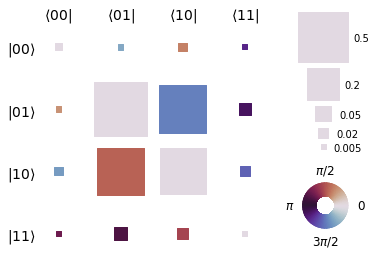

In [2]:
# Plots the phase and magnitude of the MLE estimate of the density matrix

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from itertools import product 

fig = plt.figure(figsize=(7,4), constrained_layout=False)
spec = fig.add_gridspec(2, 2, width_ratios=[6, 1], height_ratios=[3, 1], hspace=0.35, wspace=-0.2)
cmap = 'twilight_shifted'

ax0 = fig.add_subplot(spec[:, 0]) # main density matrix plot
ax01 = fig.add_subplot(spec[0, 1]) # magnitude key
ax11 = fig.add_subplot(spec[1, 1], projection='polar') # phase key

# main density matrix plot
c = np.angle(np.transpose(rho).flatten()) # color data
p = 1 # exponent for scaling tile size; the smaller this is the closer in size the tiles will be
A = 5000 # scaling factor for tile size
s = A*np.abs(rho)**p # tile size

pts = np.array(list(product(range(4), range(4))))
im0 = ax0.scatter(pts[:,0], pts[:,1], marker='s', s=s, c=c, cmap=cmap)
im0.set_clim(vmin=-np.pi, vmax=np.pi)
ax0.set_aspect('equal', 'box')
ax0.set_xlim(-0.25,3.25)
ax0.set_ylim(-0.25,3.25)

ax0.invert_yaxis()
ax0.xaxis.tick_top()
ax0.set_xticks([0,1,2,3])
ax0.set_yticks([0,1,2,3])
ax0.xaxis.set_ticks_position('none')
ax0.yaxis.set_ticks_position('none')
ax0.set_yticklabels([r'$\vert 00 \rangle$', r'$\vert 01 \rangle$', r'$\vert 10 \rangle$', r'$\vert 11 \rangle$'])
ax0.set_xticklabels([r'$\langle 00 \vert$', r'$\langle 01 \vert$', r'$\langle 10 \vert$', r'$\langle 11 \vert$'])
ax0.set_frame_on(False)
ax0.tick_params(labelsize=14) 

# magnitude key
c = np.ones(5)
s = A*np.array([0.005, 0.02, 0.05, 0.2, 0.5])**p
y = [-0.1, 0.45, 1.25, 2.45, 4.4]
pts = np.array(list(product(range(1),y)))

ax01.scatter(pts[:,0], pts[:,1], marker='s', s=s, c=c, cmap='twilight')
ax01.set_ylim(-0.25,5.45)
ax01.set_xlim(-1.75,2)
ax01.axis('off')

text_offset = 0.18 # adding and positioning text labels
ax01.text(0.6,y[0] - text_offset,'0.005')
ax01.text(0.8,y[1] - text_offset,'0.02')
ax01.text(1.0,y[2] - text_offset,'0.05')
ax01.text(1.3,y[3] - text_offset,'0.2')
ax01.text(1.85,y[4] - text_offset,'0.5')

box = ax01.get_position() # adjust key placement
box.y1 = box.y1 + 0.07
box.y0 = box.y0 + 0.07
ax01.set_position(box)

# phase key (adapted from https://stackoverflow.com/questions/31940285/plot-a-polar-color-wheel-based-on-a-colormap-using-python-matplotlib)
norm = mpl.colors.Normalize(0, 2*np.pi) 

n = 200
t = np.linspace(-np.pi,np.pi,n)
r = np.linspace(.4,1,2)
rg, tg = np.meshgrid(r,t)
c = tg

im11 = ax11.pcolormesh(t, r, c.T, cmap='twilight_shifted') # plot the colormesh on axis with colormap
ax11.set_yticklabels([])
ax11.tick_params(pad=2,labelsize=12)
ax11.spines['polar'].set_visible(False)
ax11.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])  
ax11.set_xticklabels(([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$'])) 

box = ax11.get_position() # adjust key placement
box.y1 = box.y1 + 0.07
box.y0 = box.y0 + 0.07
ax11.set_position(box)

plt.show()

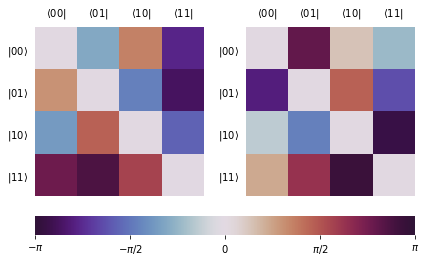

In [3]:
# Compares the phases of our MLE estimate of theta and that of Stephenson et. al.

# construct an array containing the MLE estimate of rho from Stephenson et. al.
phase = np.array([[0, -1.198, -1.861, -0.231], [1.198, 0, -1.539, -0.633], [1.861, 1.539, 0, -0.934], [0.231, 0.633, 0.934, 0]])
rho_s = np.array([np.exp(1j * np.pi * phi) for phi in phase])
rho_s = np.multiply(np.abs(rho).astype(np.cdouble), rho_s) # uses the magnitudes we obtained since they are identical

fig, axs = plt.subplots(ncols=2, figsize=(6,6))
fig.tight_layout()

cmap='twilight_shifted'
mp0 = axs[0].matshow(np.angle(rho), cmap=cmap) # our estimate of rho
mp1 = axs[1].matshow(np.angle(rho_s), cmap=cmap) # estimate of rho from Stephenson et. al.
mp0.set_clim(vmin=-np.pi, vmax=np.pi)
mp1.set_clim(vmin=-np.pi, vmax=np.pi)
cbar = plt.colorbar(mp0, orientation='horizontal', ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi], ax=axs.ravel().tolist(), pad=0.05)
cbar.ax.set_xticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$']) 
cbar.outline.set_visible(False)

for ax in axs:  
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.set_xticks([0,1,2,3])
    ax.set_yticks([0,1,2,3])
    ax.set_yticklabels([r'$\vert 00 \rangle$', r'$\vert 01 \rangle$', r'$\vert 10 \rangle$', r'$\vert 11 \rangle$'])
    ax.set_xticklabels([r'$\langle 00 \vert$', r'$\langle 01 \vert$', r'$\langle 10 \vert$', r'$\langle 11 \vert$'])
    ax.set_frame_on(False)

plt.show()

In [4]:
# Evaluates the log-likelihood function for our estimate of rho and that of Stephenson et. al.

def log_likelihood(rho, data_arr):
    ll = 0
    for i in range(9): # iterate through each POVM measurement
        proj = projectors[i] 
        for j in range(4): # iterate through the four projectors of this POVM measurement
            ll += data_arr[i, j] * np.trace(np.dot(proj[:, :, j], rho))
    return np.real(ll)

print('our estimate: {:.2f}'.format(log_likelihood(rho, data)))
print('Stephenson et. al. estimate - {:.2f}'.format(log_likelihood(rho_s, data)))

our estimate: 2888.25
Stephenson et. al. estimate - 2106.70


In [5]:
# Generates parametric bootstrap samples and performs maximum likelihood estimation of the bootstrap density matrices

verbose = False # set to True to track the progress as the script is running

bootstrap_samples = 2500
bootstrap_data = np.zeros([9, 4, bootstrap_samples]) # store each 9x4 data table in a layer
bootstrap_rho = np.zeros([4, 4, bootstrap_samples]).astype(np.cdouble) # store each 9x4 data table in a layer

POVM_counts = np.sum(data, axis=1).astype(int) # count the number of measurements in each experiment for consistency
if verbose: print('Generating bootstrapping samples...')

for s in range(bootstrap_samples):
    for i in range(9):
        proj = projectors[i]
        uniform = np.random.rand(POVM_counts[i])
        pmf = np.array([np.real(np.trace(proj[:, :, j] @ rho)) for j in range(4)]) # calculate the pmf of the four measurement outcomes
        cdf = np.insert(np.cumsum(pmf), 0, 0) # calculate the cumulative distribution for determining bins
        
        for j in range(4):
            bootstrap_data[i, j, s] = ((cdf[j] < uniform) & (uniform <= cdf[j + 1])).sum() # count the number of uniform datapoints in each bin
        
    bootstrap_rho[:, :, s] = find_MLE(bootstrap_data[:, :, s], 1e-5)[0] # estimate the density matrix for each bootstrap sample
    if s % 100 == 0 and verbose: print(str(s) + '/' + str(bootstrap_samples))
    
if verbose: print('Done.')

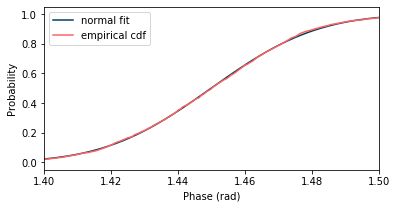

In [6]:
# Plots the empirical distribution of the phase of the (3, 2) component of the bootstrap density matrices

from scipy.special import erf

phi = np.array([np.angle(bootstrap_rho[2,1,s]) for s in range(bootstrap_samples)])
emp_cdf = lambda x : np.size(phi[phi <= x]) / len(phi) # empirical cdf of the data
N = 250
x_arr = np.linspace(np.min(phi), np.max(phi), N)
y_arr = np.array([emp_cdf(x) for x in x_arr])

z_arr = (x_arr - np.mean(phi)) / np.std(phi) # apparent variation is closer to 80% of this
Phi = lambda z : (1 + erf(z / np.sqrt(2))) / 2 # standard normal cdf
normal_cdf = np.array([Phi(z) for z in z_arr]) # evaluate the normal cdf at the query x values

fig, ax = plt.subplots(figsize=(6,3))

ax.plot(x_arr, normal_cdf, '#003f5c')
ax.plot(x_arr, y_arr, '#ff6361')

ax.set_xlim(1.4, 1.5)
ax.set_xlabel('Phase (rad)')
ax.set_ylabel('Probability')
ax.legend(['normal fit', 'empirical cdf'])
plt.show()

In [7]:
# Performs a chi-squared test for normality of the (3, 2) component of the bootstrap density matrices

from scipy.stats import norm
from scipy.stats.distributions import chi2

n = len(phi)
m = 10 # number of partition intervals
bins = np.arange(0, 1 + 1/m, 1/m) # calculate partition endpoints
bins = norm.ppf(bins)
z = (phi - np.mean(phi)) / np.std(phi)
w = np.histogram(z, bins=bins)[0] 
p = 1 / m # probability for each bin

U = np.sum((w - n * p)**2) / (n * p) # observed value of the statistic U
p_value = 1 - chi2.cdf(U, df=m - 1) # calculate p value corresponding to U
print("U = {:.4f}, p-value: {:.4f}".format(U, p_value))

U = 5.5360, p-value: 0.7853


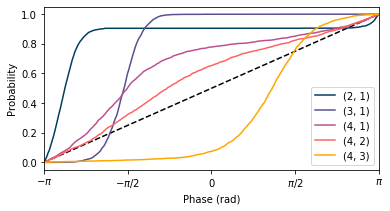

In [8]:
# Plots the empirical distribution of the phase of the outer components of the bootstrap density matrices

index_pairs = ((1,0), (2,0), (3,0), (3,1), (3,2))

phases = [np.array([np.angle(bootstrap_rho[ind[0], ind[1], s]) for s in range(bootstrap_samples)]) for ind in index_pairs]
emp_cdfs = [lambda x, ph=ph: np.size(ph[ph <= x]) / len(ph) for ph in phases]

N = 250
x_arr = np.linspace(-np.pi, np.pi, N)
y_arrs = [np.array([cdf(x) for x in x_arr]) for cdf in emp_cdfs]

colors = ['#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600']

fig, ax = plt.subplots(figsize=(6,3))
ax.plot(x_arr, np.linspace(0, 1, len(x_arr)), '#000000', linestyle='dashed', label='_nolegend_') # dashed line for uniform distribution
for i in range(len(phases)):
    ax.plot(x_arr, y_arrs[i], colors[i])

ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax.set_xticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$']) 
ax.set_xlim(-np.pi, np.pi)
ax.set_xlabel('Phase (rad)')
ax.set_ylabel('Probability')
ax.legend(['(2, 1)', '(3, 1)', '(4, 1)', '(4, 2)', '(4, 3)'])
plt.show()